In [1]:
import sys
import os

# Add the path to `database_scripts` folder
sys.path.append(os.path.abspath("../database_scripts"))
import db_utils as du
import create_tables as ct


conn = ct.create_or_open_database()
df_fahrrad_Zähler = du.fetch_data_df('Standorten_Zählstelle',conn)
df_mess_Fahrrad= du.fetch_data_df('Messdaten_Fahrrad',conn)
df_bezirke= du.fetch_data_df('Bezirke',conn)
df_date = du.fetch_data_df('Date_dim',conn)
df_time = du.fetch_data_df('Time_dim',conn)
df_wetter = du.fetch_data_df('Wetter',conn)

Establish SQLite connection.


In [2]:
df_fahrrad_Zähler.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Zählstelle          33 non-null     object
 1   Bezirk              33 non-null     object
 2   Beschreibung        33 non-null     object
 3   Installationsdatum  33 non-null     object
dtypes: object(4)
memory usage: 1.2+ KB


In [3]:
df_mess_Fahrrad['TimeID'] = df_mess_Fahrrad['TimeID'].astype('int32')
df_mess_Fahrrad['DateID'] = df_mess_Fahrrad['DateID'].astype('int32')
df_mess_Fahrrad['Wert'] = df_mess_Fahrrad['Wert'].astype('float32')
df_mess_Fahrrad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1380768 entries, 0 to 1380767
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   Zählstelle  1380768 non-null  object 
 1   DateID      1380768 non-null  int32  
 2   TimeID      1380768 non-null  int32  
 3   Wert        1343161 non-null  float32
dtypes: float32(1), int32(2), object(1)
memory usage: 26.3+ MB


In [4]:
df_bezirke.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Bezirk       12 non-null     object 
 1   Breitengrad  12 non-null     float64
 2   Längengrad   12 non-null     float64
 3   Geometry     12 non-null     object 
dtypes: float64(2), object(2)
memory usage: 516.0+ bytes


In [5]:
df_wetter.columns

Index(['DateID', 'TimeID', 'Bezirk', 'temperature_2m (°C)',
       'relative_humidity_2m (%)', 'rain (mm)', 'snowfall (cm)',
       'cloud_cover (%)'],
      dtype='object')

In [6]:
df_wetter['TimeID'] = df_wetter['TimeID'].astype('int32')
df_wetter['DateID'] = df_wetter['DateID'].astype('int32')
df_wetter['temperature_2m (°C)'] = df_wetter['temperature_2m (°C)'].astype('float32')
df_wetter['relative_humidity_2m (%)'] = df_wetter['relative_humidity_2m (%)'].astype('int32')
df_wetter['rain (mm)'] = df_wetter['rain (mm)'].astype('float32')
df_wetter['snowfall (cm)'] = df_wetter['snowfall (cm)'].astype('float32')
df_wetter['cloud_cover (%)'] = df_wetter['cloud_cover (%)'].astype('float32')
df_wetter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 631008 entries, 0 to 631007
Data columns (total 8 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   DateID                    631008 non-null  int32  
 1   TimeID                    631008 non-null  int32  
 2   Bezirk                    631008 non-null  object 
 3   temperature_2m (°C)       631008 non-null  float32
 4   relative_humidity_2m (%)  631008 non-null  int32  
 5   rain (mm)                 631008 non-null  float32
 6   snowfall (cm)             631008 non-null  float32
 7   cloud_cover (%)           631008 non-null  float32
dtypes: float32(4), int32(3), object(1)
memory usage: 21.7+ MB


In [7]:
df_mess_Fahrrad.isna().sum()

Zählstelle        0
DateID            0
TimeID            0
Wert          37607
dtype: int64

In [8]:
df_mess_Fahrrad['TimeID'] = df_mess_Fahrrad['TimeID'].astype('int32')
df_mess_Fahrrad['DateID'] = df_mess_Fahrrad['DateID'].astype('int32')
df_mess_Fahrrad['Wert'] = df_mess_Fahrrad['Wert'].astype('float32')
df_mess_Fahrrad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1380768 entries, 0 to 1380767
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   Zählstelle  1380768 non-null  object 
 1   DateID      1380768 non-null  int32  
 2   TimeID      1380768 non-null  int32  
 3   Wert        1343161 non-null  float32
dtypes: float32(1), int32(2), object(1)
memory usage: 26.3+ MB


In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
df_mess_Fahrrad.isna()

,Zählstelle,DateID,TimeID,Wert
0,False,False,False,False
1,False,False,False,False
2,False,False,False,False
3,False,False,False,False
4,False,False,False,False
...,...,...,...,...
1380763,False,False,False,False
1380764,False,False,False,False
1380765,False,False,False,False
1380766,False,False,False,False


In [11]:
df_merged = df_mess_Fahrrad.merge(df_fahrrad_Zähler, on='Zählstelle', how='left')

# 2. Wetterdaten hinzufügen (über DateID und optional Bezirk)
df_merged = df_merged.merge(df_wetter, on=['DateID','TimeID', 'Bezirk'], how='left')

print(df_merged.info())
print(df_merged.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1380768 entries, 0 to 1380767
Data columns (total 12 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   Zählstelle                1380768 non-null  object 
 1   DateID                    1380768 non-null  int32  
 2   TimeID                    1380768 non-null  int32  
 3   Wert                      1343161 non-null  float32
 4   Bezirk                    1380768 non-null  object 
 5   Beschreibung              1380768 non-null  object 
 6   Installationsdatum        1380768 non-null  object 
 7   temperature_2m (°C)       1380768 non-null  float32
 8   relative_humidity_2m (%)  1380768 non-null  int32  
 9   rain (mm)                 1380768 non-null  float32
 10  snowfall (cm)             1380768 non-null  float32
 11  cloud_cover (%)           1380768 non-null  float32
dtypes: float32(5), int32(3), object(4)
memory usage: 84.3+ MB
None
    Zählstelle  DateI

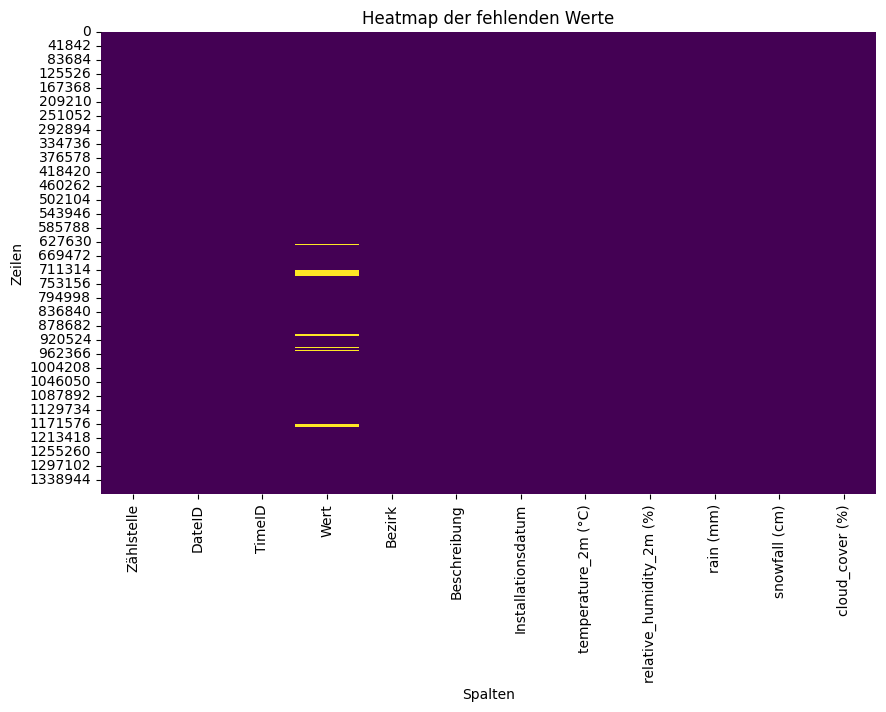

In [12]:

plt.figure(figsize=(10, 6))
sns.heatmap(df_merged.isna(), cbar=False, cmap='viridis')
plt.title('Heatmap der fehlenden Werte')
plt.xlabel('Spalten')
plt.ylabel('Zeilen')
plt.show()

In [13]:
df_bezirke

,Bezirk,Breitengrad,Längengrad,Geometry
0,Charlottenburg-Wilmersdorf,52.501049,13.270236,"POLYGON ((13.1881678 52.4718369, 13.1882878 52..."
1,Friedrichshain-Kreuzberg,52.503831,13.428232,"POLYGON ((13.3685807 52.4939555, 13.3684148 52..."
2,Lichtenberg,52.534895,13.509767,"POLYGON ((13.5169886 52.5354135, 13.517064 52...."
3,Marzahn-Hellersdorf,52.521115,13.578833,"POLYGON ((13.5168837 52.5355476, 13.5170363 52..."
4,Mitte,52.532878,13.365911,"POLYGON ((13.4041908 52.5404013, 13.4047046 52..."
5,Neukölln,52.441087,13.454967,"POLYGON ((13.3999243 52.4185371, 13.4001226 52..."
6,Pankow,52.597193,13.440249,"MULTIPOLYGON (((13.3883808 52.5676794, 13.3884..."
7,Reinickendorf,52.595678,13.291329,"POLYGON ((13.3491334 52.5892003, 13.3497913 52..."
8,Spandau,52.525795,13.178813,"POLYGON ((13.1095585 52.4510789, 13.1097339 52..."
9,Steglitz-Zehlendorf,52.434849,13.239081,"POLYGON ((13.088345 52.4196325, 13.0958391 52...."


In [14]:
df_time

,TimeID,time_of_the_day
0,0,nachts
1,1,nachts
2,2,nachts
3,3,nachts
4,4,morgens
5,5,morgens
6,6,morgens
7,7,morgens
8,8,morgens
9,9,morgens


In [15]:
df_wetter.isna().sum()

DateID                      0
TimeID                      0
Bezirk                      0
temperature_2m (°C)         0
relative_humidity_2m (%)    0
rain (mm)                   0
snowfall (cm)               0
cloud_cover (%)             0
dtype: int64

In [16]:
import pandas as pd

#Merge with Wetter
# wenn mit Durschnitt on join would be TimeID auch aber hier wir können auch nach Bezirk joinen
df_merged = pd.merge(df_mess_Fahrrad, df_wetter, on=['DateID','TimeID'],how='inner') 
df_merged.head(10)

,Zählstelle,DateID,TimeID,Wert,Bezirk,temperature_2m (°C),relative_humidity_2m (%),rain (mm),snowfall (cm),cloud_cover (%)
0,02-MI-JAN-N,2,0,6.0,Charlottenburg-Wilmersdorf,3.6,83,0.0,0.0,100.0
1,02-MI-JAN-N,2,0,6.0,Friedrichshain-Kreuzberg,3.5,83,0.0,0.0,100.0
2,02-MI-JAN-N,2,0,6.0,Lichtenberg,3.0,87,0.0,0.0,100.0
3,02-MI-JAN-N,2,0,6.0,Marzahn-Hellersdorf,2.9,87,0.0,0.0,100.0
4,02-MI-JAN-N,2,0,6.0,Mitte,3.3,85,0.0,0.0,100.0
5,02-MI-JAN-N,2,0,6.0,Neukölln,3.6,83,0.0,0.0,100.0
6,02-MI-JAN-N,2,0,6.0,Pankow,3.2,85,0.0,0.0,100.0
7,02-MI-JAN-N,2,0,6.0,Reinickendorf,3.4,85,0.0,0.0,100.0
8,02-MI-JAN-N,2,0,6.0,Spandau,3.6,83,0.0,0.0,100.0
9,02-MI-JAN-N,2,0,6.0,Steglitz-Zehlendorf,4.2,79,0.0,0.0,100.0


In [17]:
df_merged = pd.merge(df_mess_Fahrrad, df_mess_Fahrrad, on="Zählstelle", how="inner")

# Merge with Date_dim on Installationsdatum and Date
df_merged = pd.merge(df_merged, df_date, on="DateID", how="inner")

# Merge with time_dim on Installationsdatum time
df_merged = pd.merge(df_merged, df_time, on='TimeID', how="inner")


# Display the merged da
df_merged.head()

MemoryError: Unable to allocate 525. GiB for an array with shape (70426642176,) and data type int64